## Use Case

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab 
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)


C:\Users\Admin\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#Load the dataset
df_data = pd.read_csv('big_mart_data.csv')
df_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Feature description

* Item_Identifier :  Unique product ID

* Item_Weight :  Weight of the product

* Item_Fat_Content :  Whether the product is low fat or not

* Item_Visibility :  The % of total display area of all products in a store allocated to the particular product

* Item_Type :  The category to which the product belongs

* Item_MRP :  Maximum Retail Price (list price) of the product

* Outlet_Identifier :  Unique store ID

* Outlet_Establishment_Year :  The year in which store was established

* Outlet_Size :  The size of the store in terms of ground area covered

* Outlet_Location_Type :  The type of city in which the store is located

* Outlet_Type :  Whether the outlet is just a grocery store or some sort of supermarket

* Item_Outlet_Sales :  Sales of the product in the particular store. This is the outcome variable to be predicted.

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df_data.shape

(8523, 12)

## EDA

### Check missing values

In [5]:
#Missing values in each feature
df_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
#Get categorical and numerical features
num_cols = [cname for cname in df_data.columns if df_data[cname].dtype!='object']
cat_cols = [cname for cname in df_data.columns if df_data[cname].dtype=='object']

print('Numerical features: ', num_cols)
print('Categorical features: ', cat_cols)

Numerical features:  ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
Categorical features:  ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


### Check for outliers

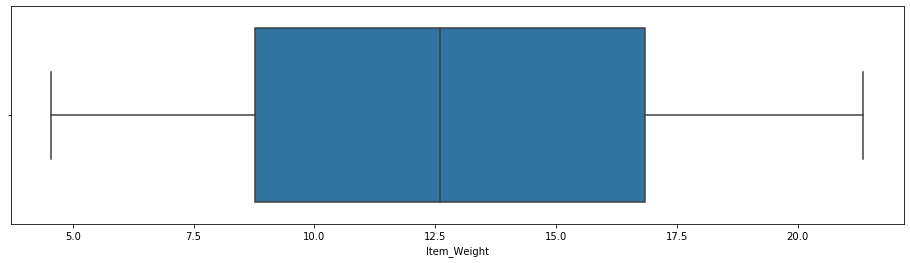

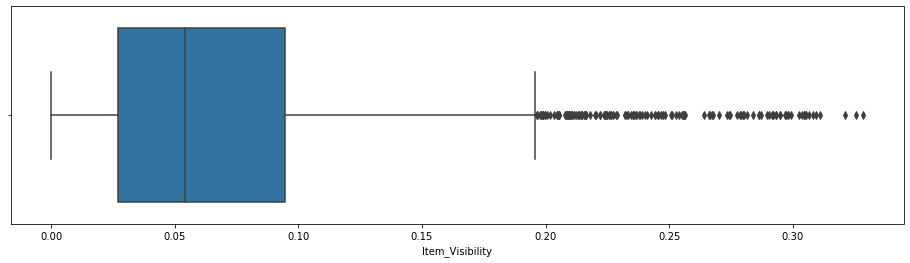

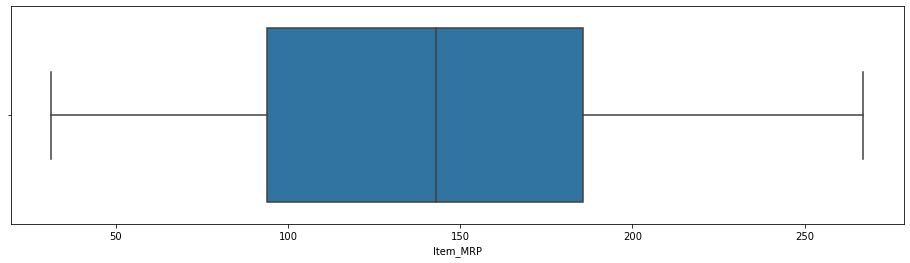

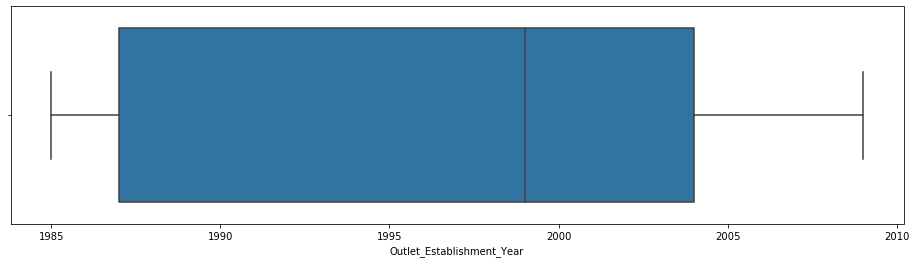

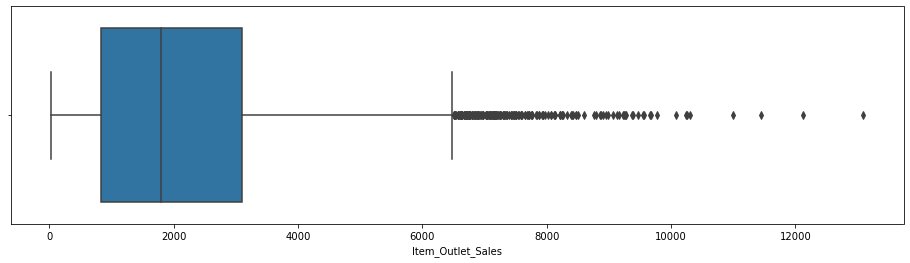

In [7]:
#Check for outliers
for column in num_cols:
    plt.figure(figsize=(16, 4))
    #sns.set_theme(style="whitegrid")
    sns.boxplot(df_data[column])

### Data distribution

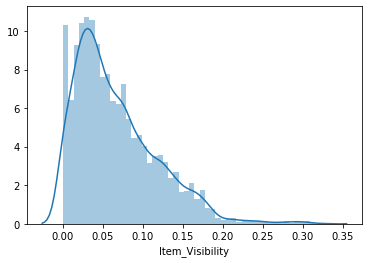

In [8]:
sns.distplot(a=df_data['Item_Visibility'])

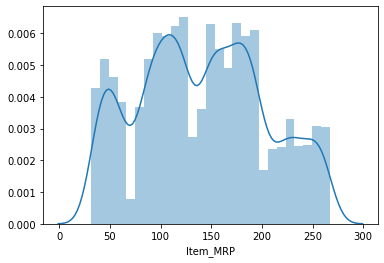

In [9]:
sns.distplot(a=df_data['Item_MRP'])

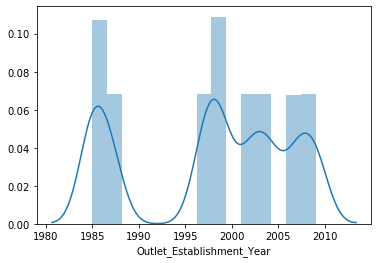

In [10]:
sns.distplot(a=df_data['Outlet_Establishment_Year'])

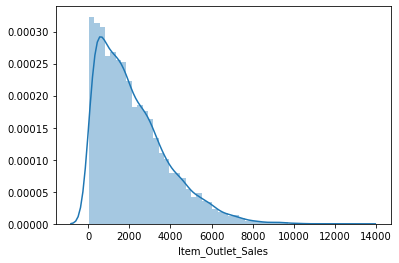

In [11]:
sns.distplot(a=df_data['Item_Outlet_Sales'])

In [12]:
cat_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

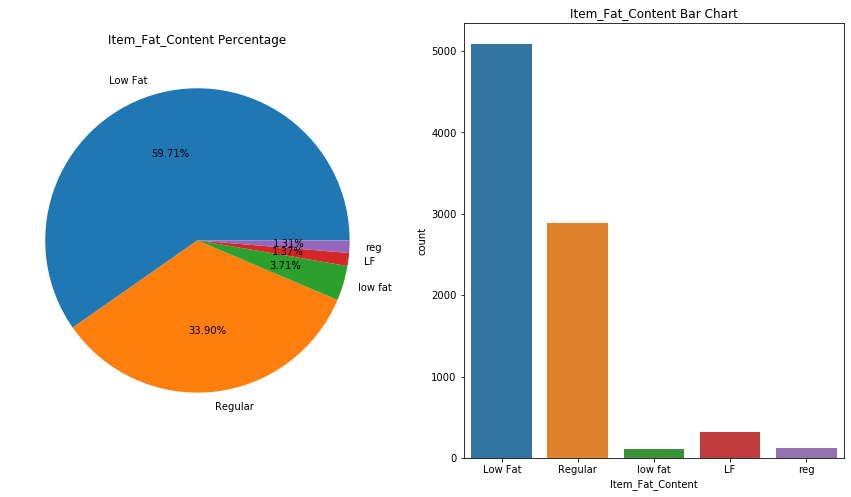

In [13]:
#sns.countplot(data=df_data, x='Item_Fat_Content')

labels=df_data['Item_Fat_Content'].dropna().unique()
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Item_Fat_Content Percentage')
plt.pie(df_data['Item_Fat_Content'].value_counts(), 
        labels=labels,  
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('Item_Fat_Content Bar Chart')
sns.countplot(x="Item_Fat_Content", data=df_data)

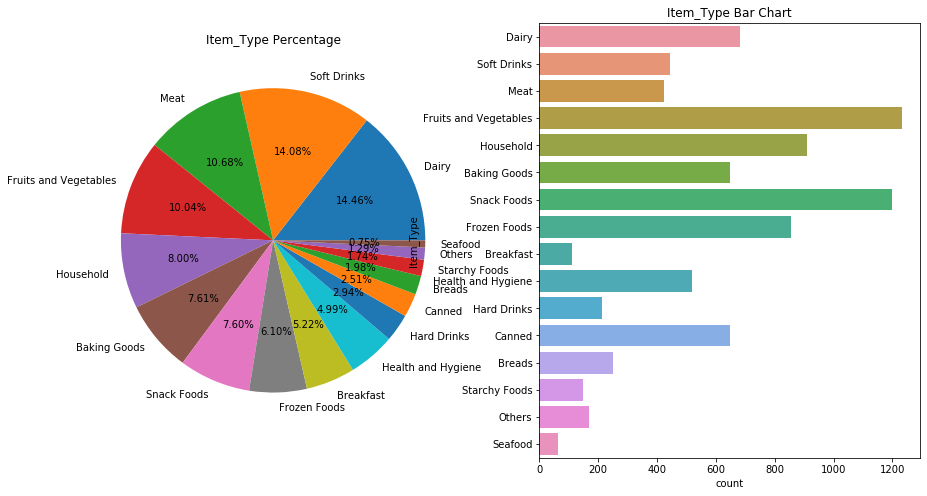

In [14]:
#sns.countplot(data=df_data, y='Item_Type')

labels=df_data['Item_Type'].dropna().unique()
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Item_Type Percentage')
plt.pie(df_data['Item_Type'].value_counts(), 
        labels=labels,  
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('Item_Type Bar Chart')
sns.countplot(y="Item_Type", data=df_data)

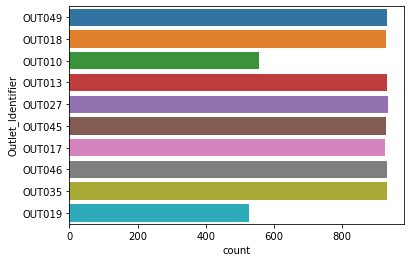

In [15]:
sns.countplot(data=df_data, y='Outlet_Identifier')

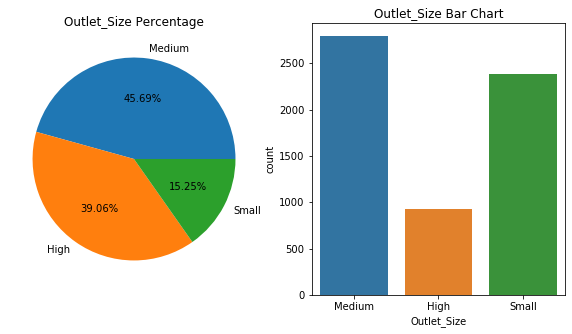

In [16]:
#sns.countplot(data=df_data, x='Outlet_Size')

labels=df_data['Outlet_Size'].dropna().unique()
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Outlet_Size Percentage')
plt.pie(df_data['Outlet_Size'].value_counts(), 
        labels=labels,  
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('Outlet_Size Bar Chart')
sns.countplot(x="Outlet_Size", data=df_data)

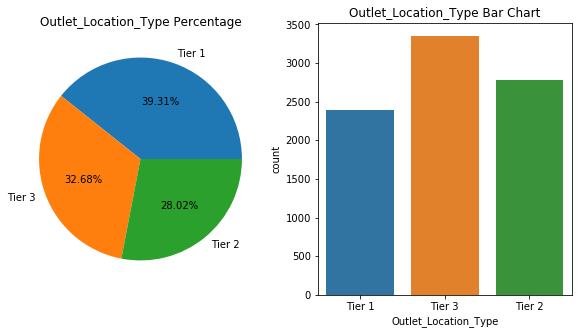

In [17]:
#sns.countplot(data=df_data, x='Outlet_Location_Type')

labels=df_data['Outlet_Location_Type'].dropna().unique()
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Outlet_Location_Type Percentage')
plt.pie(df_data['Outlet_Location_Type'].value_counts(), 
        labels=labels,  
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('Outlet_Location_Type Bar Chart')
sns.countplot(x="Outlet_Location_Type", data=df_data)

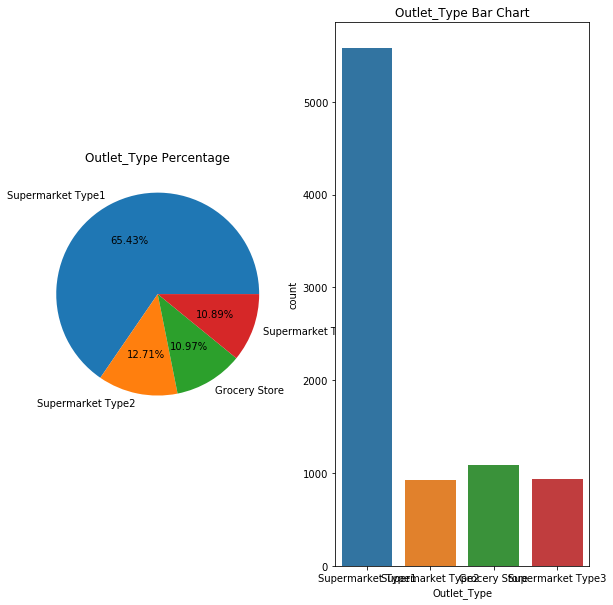

In [18]:
#sns.countplot(data=df_data, x='Outlet_Type')

labels=df_data['Outlet_Type'].dropna().unique()
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Outlet_Type Percentage')
plt.pie(df_data['Outlet_Type'].value_counts(), 
        labels=labels,  
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('Outlet_Type Bar Chart')
sns.countplot(x="Outlet_Type", data=df_data)

### Correlation

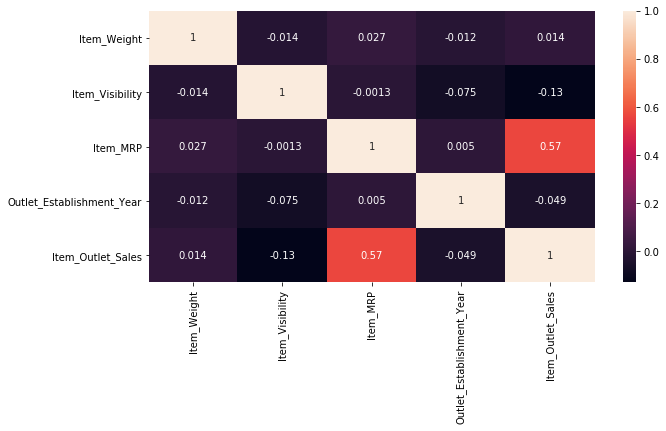

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(df_data.corr(), annot=True)

## Data preprocessing

### Handling outliers

In [20]:
# Function for IQR
def handle_outliers(DataFrame,feature):
    IQR=DataFrame[feature].quantile(0.75)-DataFrame[feature].quantile(0.25)
    lower_limit=DataFrame[feature].quantile(0.25)-(IQR*1.5)
    upper_limit=DataFrame[feature].quantile(0.75)+(IQR*1.5)
    #print(lower_limit, upper_limit)
    
    DataFrame.loc[DataFrame[feature]>=upper_limit,feature]=upper_limit
    DataFrame.loc[DataFrame[feature]<=lower_limit,feature]=lower_limit
    
    return DataFrame[feature]

In [21]:
num_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [22]:
for i in num_cols:
    df_data[i] = handle_outliers(df_data,i)

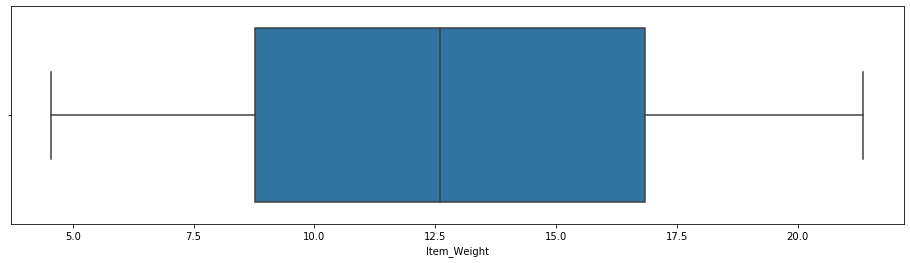

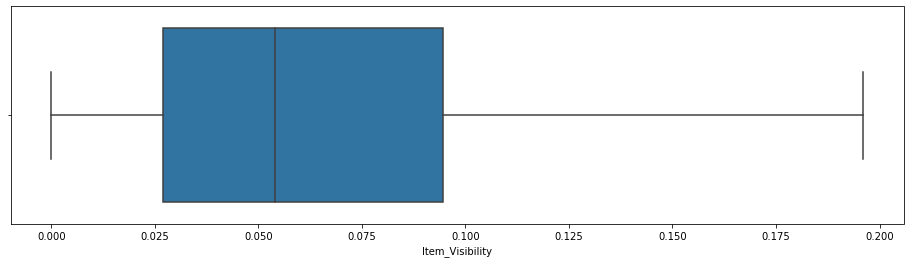

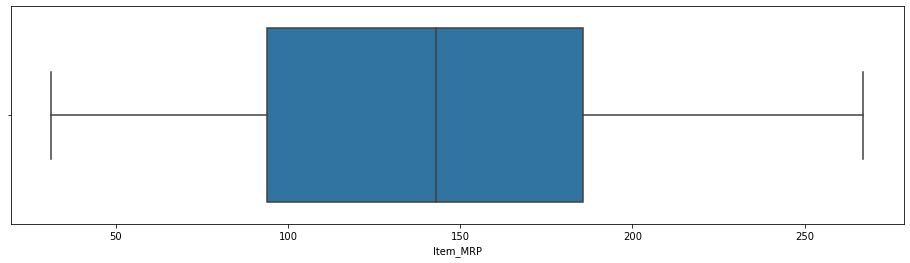

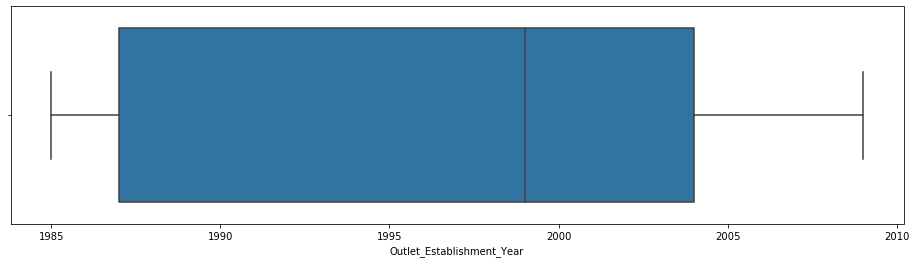

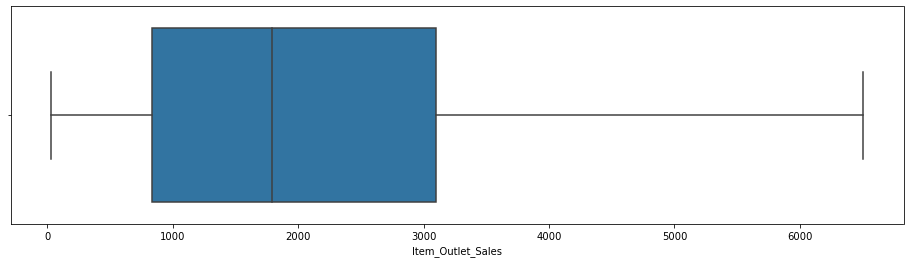

In [23]:
#After handling outliers
for column in num_cols:
    plt.figure(figsize=(16, 4))
    #sns.set_theme(style="whitegrid")
    sns.boxplot(df_data[column])

### Handle missing values

The features having missing values are:-
    * Item_Weight - numerical feature   - 1463 missing values
    * Outlet_Size - categorical feature - 2410 missing values

In [24]:
df_data.groupby(['Outlet_Type', 'Outlet_Size', 'Outlet_Identifier'], dropna=False)['Item_Identifier'].nunique().reset_index().sort_values(by=['Outlet_Size'])

,Outlet_Type,Outlet_Size,Outlet_Identifier,Item_Identifier
2,Supermarket Type1,High,OUT013,932
3,Supermarket Type1,Medium,OUT049,930
8,Supermarket Type2,Medium,OUT018,928
9,Supermarket Type3,Medium,OUT027,935
0,Grocery Store,Small,OUT019,528
4,Supermarket Type1,Small,OUT035,930
5,Supermarket Type1,Small,OUT046,930
1,Grocery Store,NaN,OUT010,555
6,Supermarket Type1,NaN,OUT017,926
7,Supermarket Type1,NaN,OUT045,929


We will impute the missing Grocery Store Outlet_Size with 'Small' and Supermarket Type1 with 'Small'

In [25]:
df_data['Outlet_Size'] = df_data['Outlet_Size'].replace(np.nan, 'Small')

We will fill the missing values in Item_weight by bfill and ffill

In [26]:
df_data['Item_Weight'] = df_data.groupby('Item_Identifier')['Item_Weight'].fillna(method='ffill')

In [27]:
df_data['Item_Weight'] = df_data.groupby('Item_Identifier')['Item_Weight'].fillna(method='bfill')

fill if any missing values with mean of the column

In [28]:
df_data['Item_Weight']=df_data['Item_Weight'].fillna(df_data['Item_Weight'].mean())

In [29]:
#check if the missing values have been handled
df_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [30]:
df_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998.0,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052


### Drop features that are not required

In [31]:
df_data.drop('Item_Identifier', axis=1, inplace=True)

In [32]:
df_data['Outlet_Age'] = 2022 - df_data['Outlet_Establishment_Year']
df_data.drop('Outlet_Establishment_Year', axis=1, inplace=True)
df_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,23.0
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,13.0
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,23.0
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,24.0
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,35.0


### Feature Transformation

In [33]:
df_data2 = df_data.copy(deep=True)

In [34]:
#Get categorical and numerical features
num_cols = [cname for cname in df_data2.columns if df_data[cname].dtype!='object']
cat_cols = [cname for cname in df_data2.columns if df_data[cname].dtype=='object']

print('Numerical features: ', num_cols)
print('Categorical features: ', cat_cols)

Numerical features:  ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales', 'Outlet_Age']
Categorical features:  ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [35]:
#Remove the spaces in between the categorical features
for cname in cat_cols:
    df_data2[cname] = df_data2[cname].str.replace(" ","_")
df_data2.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,9.30,Low_Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier_1,Supermarket_Type1,3735.1380,23.0
1,5.92,Regular,0.019278,Soft_Drinks,48.2692,OUT018,Medium,Tier_3,Supermarket_Type2,443.4228,13.0
2,17.50,Low_Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier_1,Supermarket_Type1,2097.2700,23.0
3,19.20,Regular,0.000000,Fruits_and_Vegetables,182.0950,OUT010,Small,Tier_3,Grocery_Store,732.3800,24.0
4,8.93,Low_Fat,0.000000,Household,53.8614,OUT013,High,Tier_3,Supermarket_Type1,994.7052,35.0


In [36]:
df_data2.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.875420,0.065307,140.992782,2156.313016,24.168133
std,4.645008,0.048841,62.275067,1624.863069,8.371760
min,4.555000,0.000000,31.290000,33.290000,13.000000
25%,8.785000,0.026989,93.826500,834.247400,18.000000
50%,12.650000,0.053931,143.012800,1794.331000,23.000000
75%,16.850000,0.094585,185.643700,3101.296400,35.000000
max,21.350000,0.195979,266.888400,6501.869900,37.000000


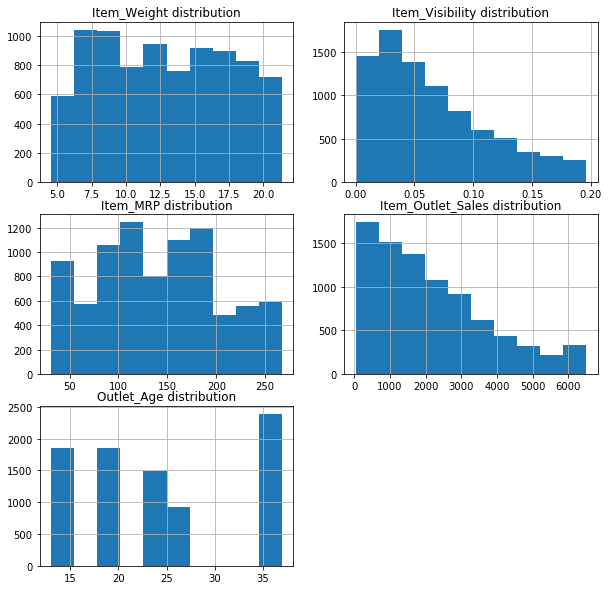

In [37]:
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.title('Item_Weight distribution')
df_data2['Item_Weight'].hist()

plt.subplot(3,2,2)
plt.title('Item_Visibility distribution')
df_data2['Item_Visibility'].hist()

plt.subplot(3,2,3)
plt.title('Item_MRP distribution')
df_data2['Item_MRP'].hist()

plt.subplot(3,2,4)
plt.title('Item_Outlet_Sales distribution')
df_data2['Item_Outlet_Sales'].hist()

plt.subplot(3,2,5)
plt.title('Outlet_Age distribution')
df_data2['Outlet_Age'].hist()

In [38]:
#QQ plot
def plot_data(df):
    for feature in df.columns:
        print(feature)
        plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        df[feature].hist()
        plt.subplot(1,2,2)
        scipy.stats.probplot(df[feature],dist='norm',plot=pylab)
        plt.show()

As the 'Item_Visibility' feature has a minimum value of 0, we will use +1 wherever required

In [39]:
#1.Apply log transformation
for column in num_cols:
    df_data2[column+'_log'] = np.log(df_data2[column]+1)

In [40]:
#2. Reciprocal transformation
for column in num_cols:
    df_data2[column+'_rec']=1/(df_data2[column]+1)

In [41]:
#3. Square root transformation
for column in num_cols:
    df_data2[column+'_sqaure']=df_data2[column]**(1/2)

In [42]:
#4. Exponential transformation
for column in num_cols:
    df_data2[column+'_exp']=df_data2[column]**(1/1.2)

In [43]:
def analyze_individual_feature_transf(df,feature):
    df_ft=df[[feature+'_log', feature+'_rec', feature+'_sqaure', feature+'_exp']].copy()
    plot_data(df_ft)

Item_Weight_log


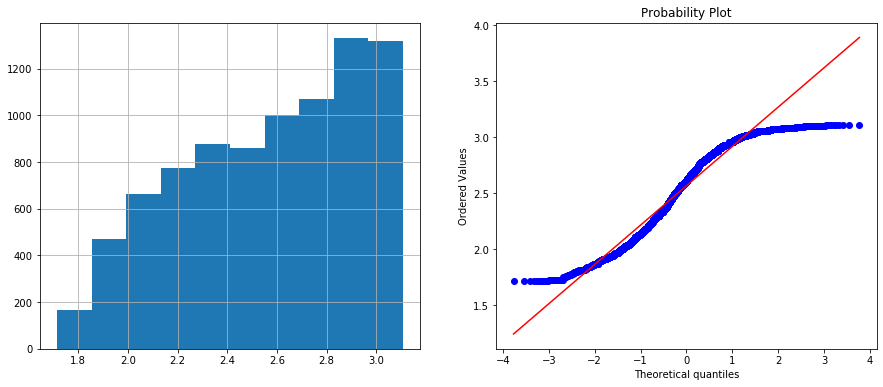

Item_Weight_rec


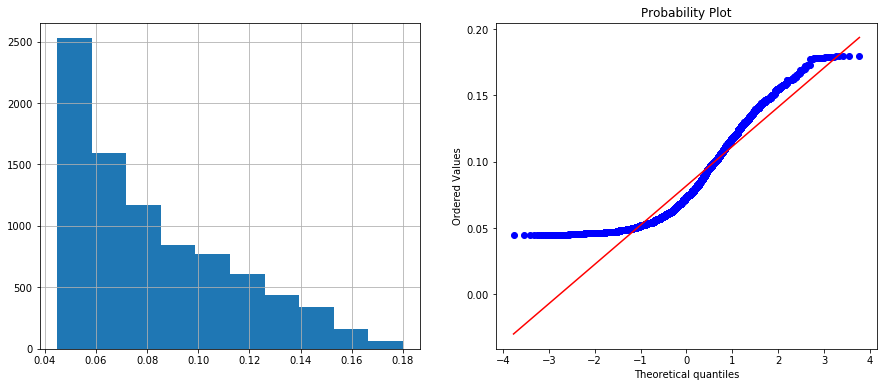

Item_Weight_sqaure


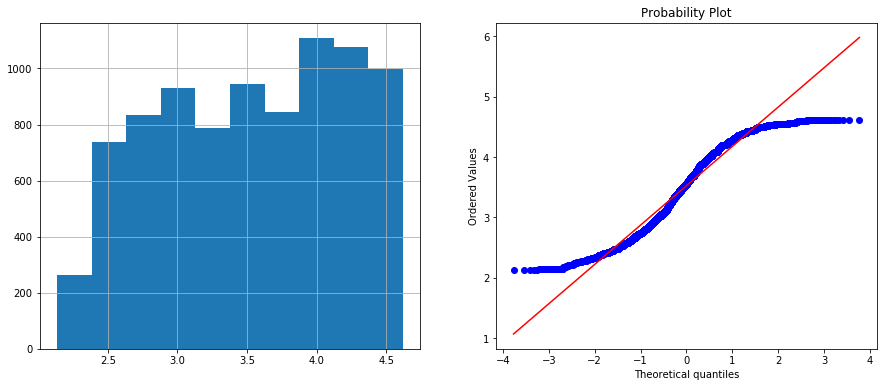

Item_Weight_exp


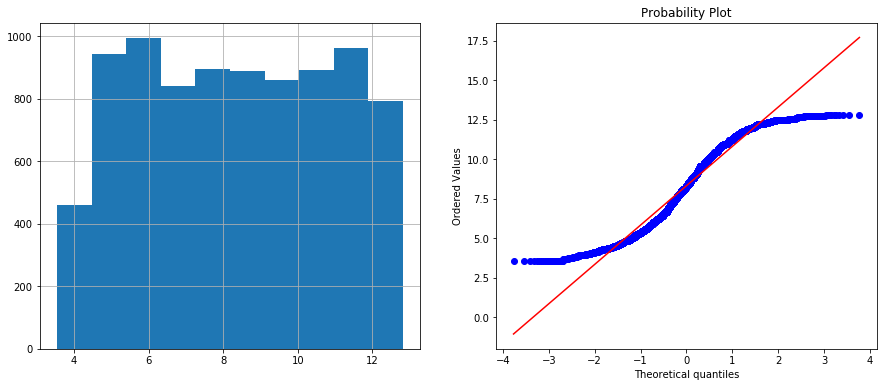

In [44]:
#Analyze the different feature transformation techniques for 'Item_Weight'
analyze_individual_feature_transf(df_data2, 'Item_Weight')

Item_Visibility_log


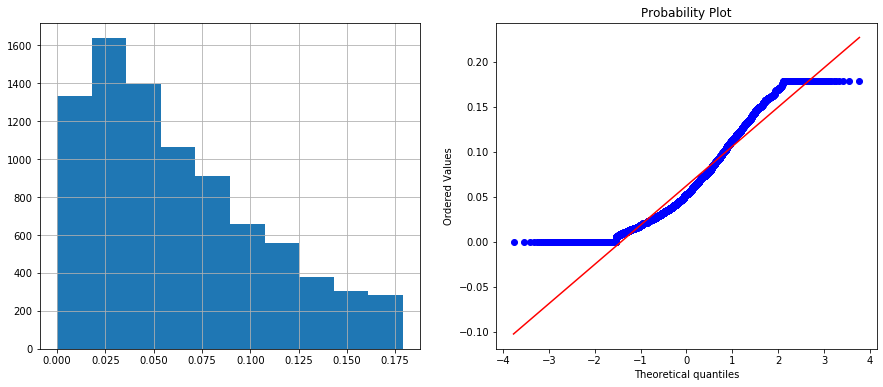

Item_Visibility_rec


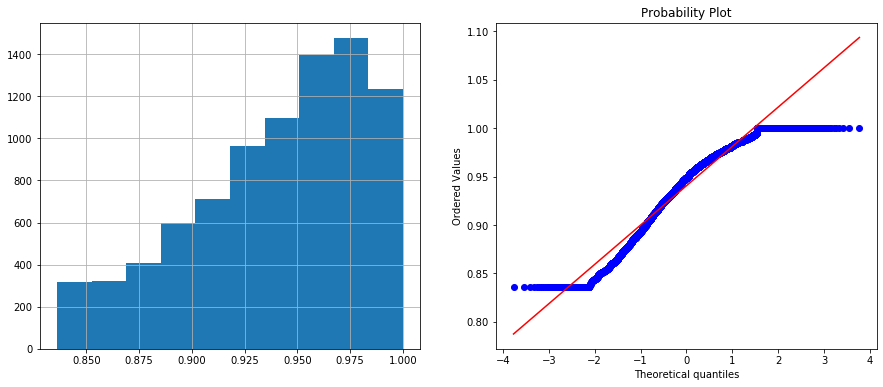

Item_Visibility_sqaure


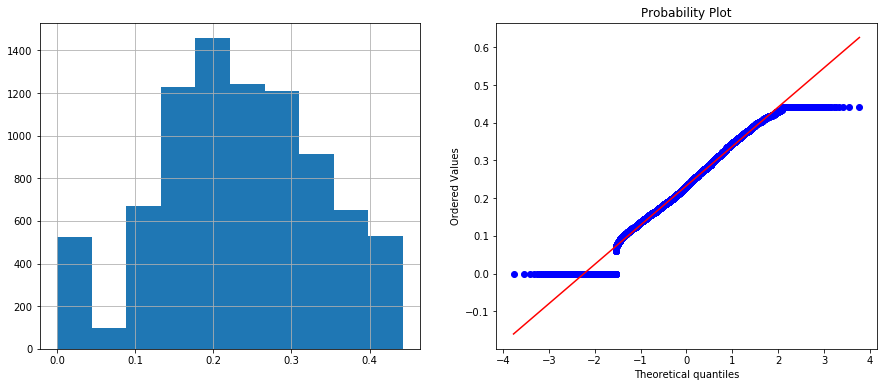

Item_Visibility_exp


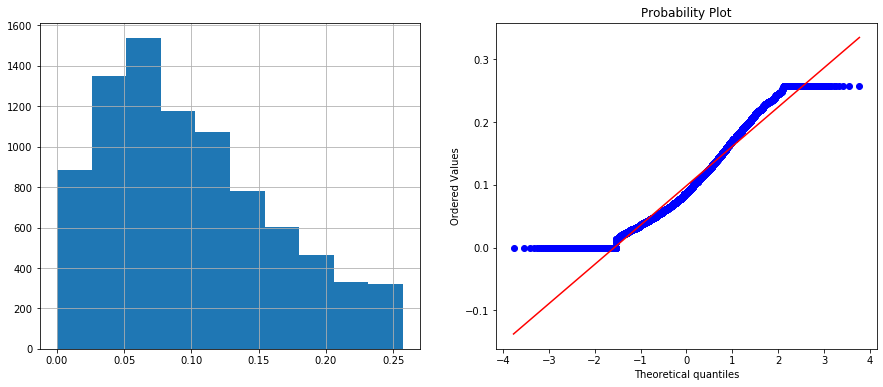

In [45]:
#Analyze the different feature transformation techniques for 'Item_Visibility'
analyze_individual_feature_transf(df_data2, 'Item_Visibility')

Item_MRP_log


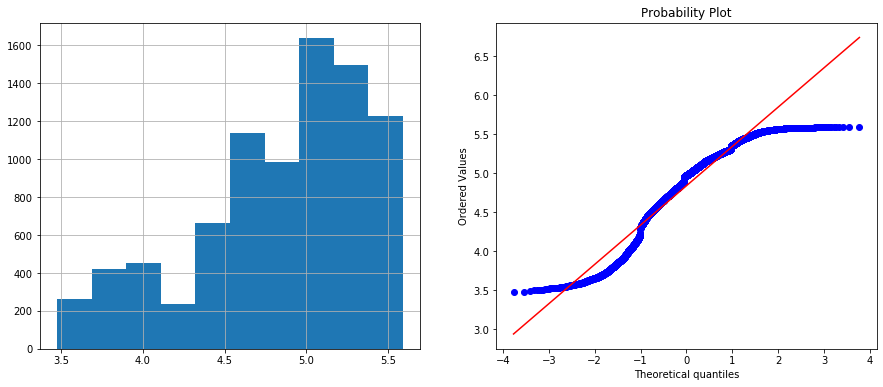

Item_MRP_rec


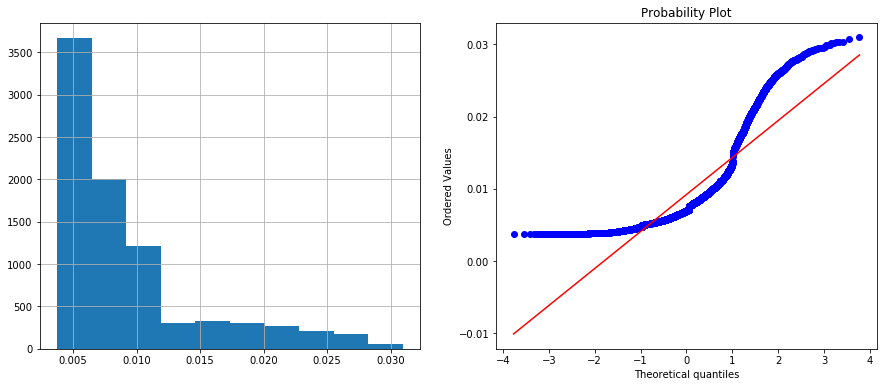

Item_MRP_sqaure


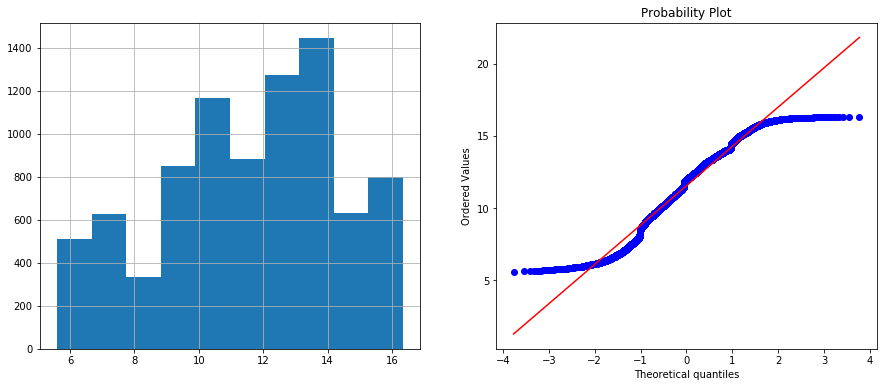

Item_MRP_exp


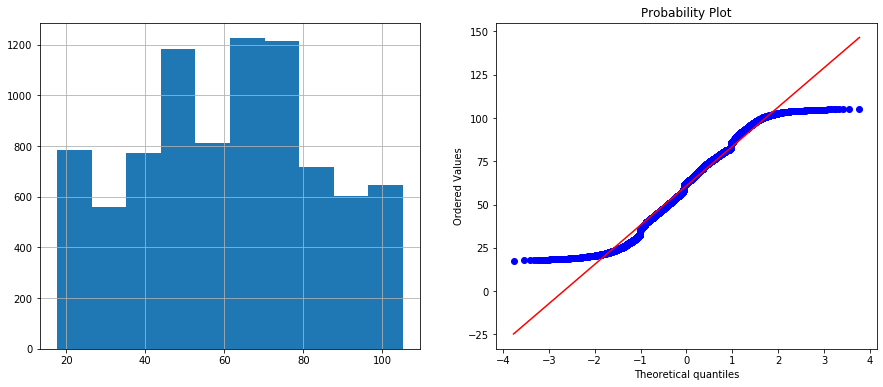

In [46]:
#Analyze the different feature transformation techniques for 'Item_MRP'
analyze_individual_feature_transf(df_data2, 'Item_MRP')

Item_Outlet_Sales_log


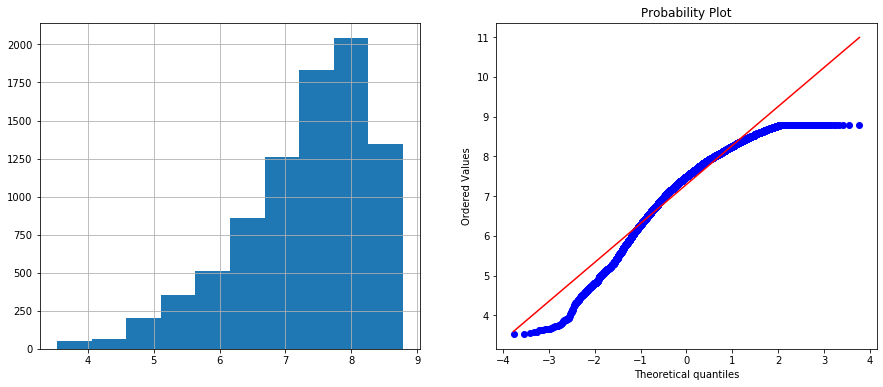

Item_Outlet_Sales_rec


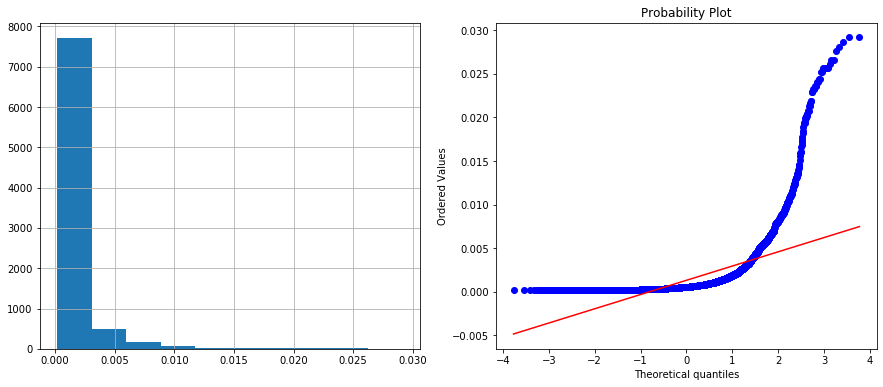

Item_Outlet_Sales_sqaure


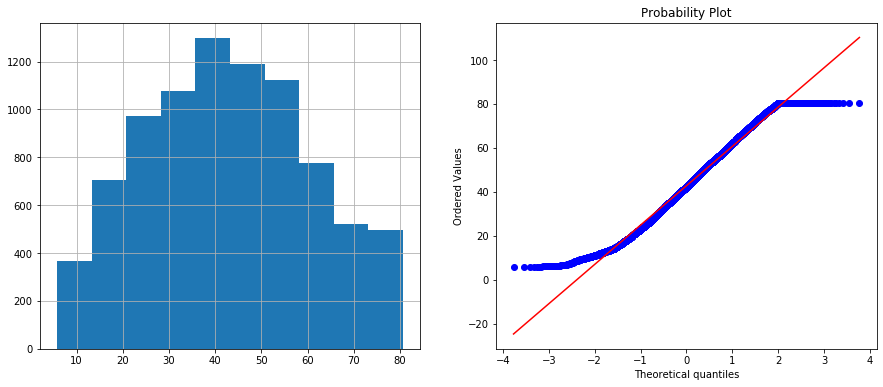

Item_Outlet_Sales_exp


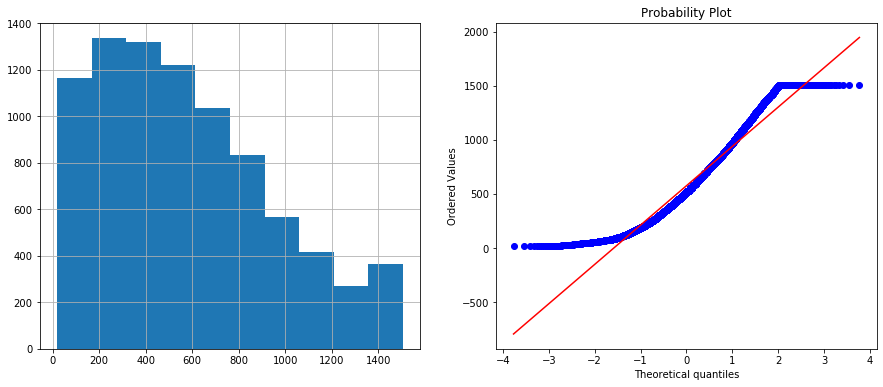

In [47]:
#Analyze the different feature transformation techniques for 'Item_Outlet_Sales'
analyze_individual_feature_transf(df_data2, 'Item_Outlet_Sales')

Outlet_Age_log


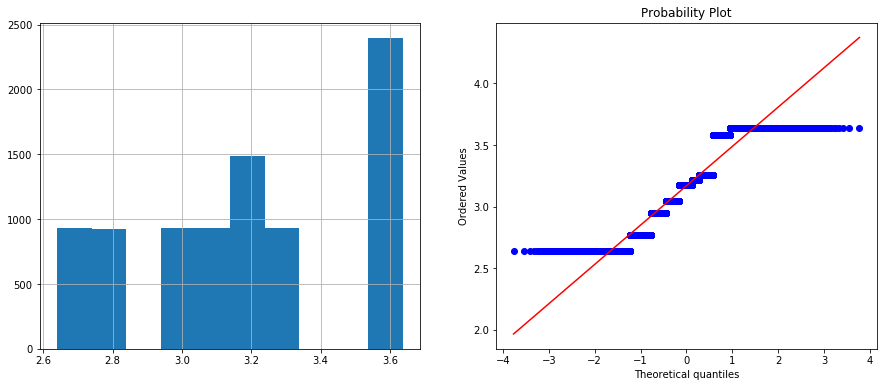

Outlet_Age_rec


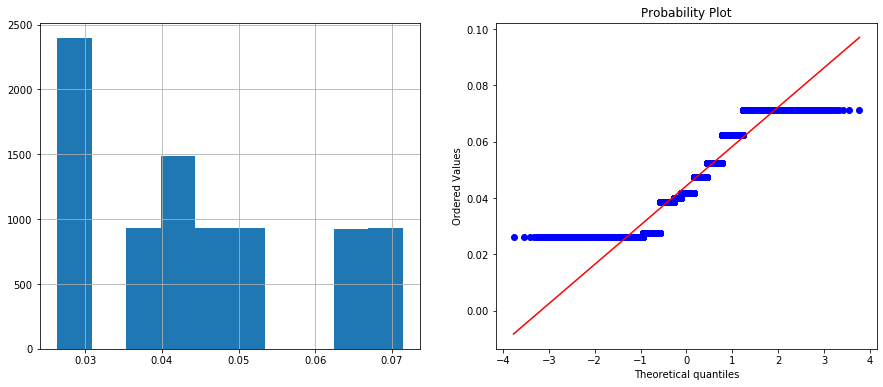

Outlet_Age_sqaure


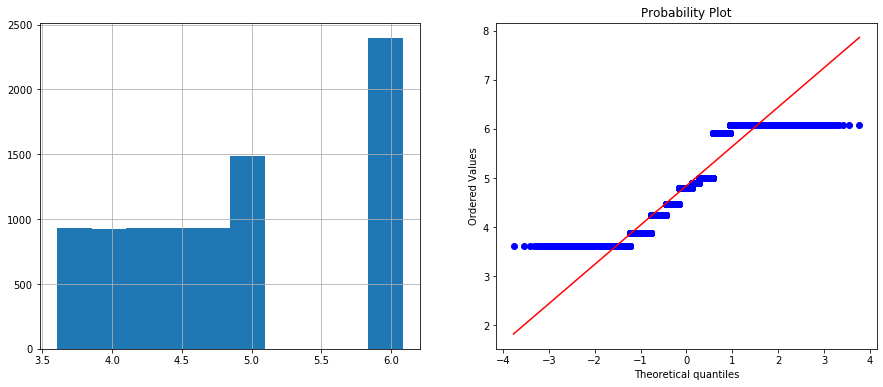

Outlet_Age_exp


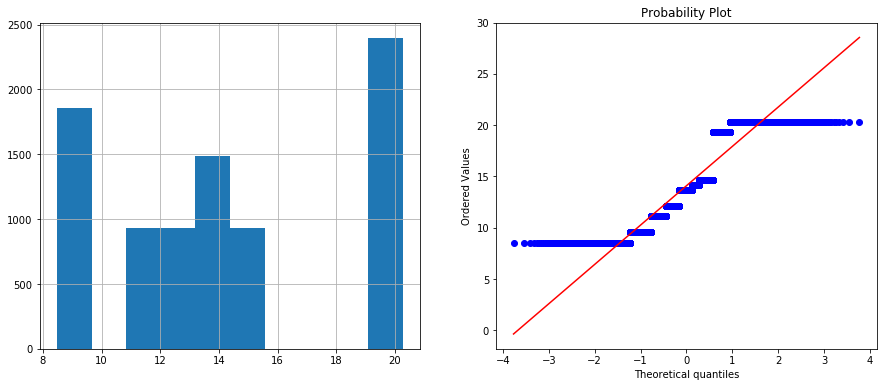

In [48]:
#Analyze the different feature transformation techniques for 'Outlet_Age'
analyze_individual_feature_transf(df_data2, 'Outlet_Age')

We will choose :- 'Item_Weight_exp', 'Item_Visibility_sqaure', 'Item_MRP_exp', 'Item_Outlet_Sales_sqaure', 'Outlet_Age_sqaure'

In [49]:
df_data3 = df_data2[['Item_Weight_exp', 'Item_Fat_Content', 'Item_Visibility_sqaure', 'Item_Type',
                     'Item_MRP_exp', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
                     'Item_Outlet_Sales_sqaure', 'Outlet_Age_sqaure', 'Outlet_Identifier']].copy(deep=True)

df_data3.head()

,Item_Weight_exp,Item_Fat_Content,Item_Visibility_sqaure,Item_Type,Item_MRP_exp,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales_sqaure,Outlet_Age_sqaure,Outlet_Identifier
0,6.413116,Low_Fat,0.126678,Dairy,99.542152,Medium,Tier_1,Supermarket_Type1,61.115775,4.795832,OUT049
1,4.401507,Regular,0.138846,Soft_Drinks,25.296382,Medium,Tier_3,Supermarket_Type2,21.057607,3.605551,OUT018
2,10.860881,Low_Fat,0.129461,Meat,62.029562,Medium,Tier_1,Supermarket_Type1,45.795961,4.795832,OUT049
3,11.733233,Regular,0.000000,Fruits_and_Vegetables,76.485953,Small,Tier_3,Grocery_Store,27.062520,4.898979,OUT010
4,6.199779,Low_Fat,0.000000,Household,27.716052,High,Tier_3,Supermarket_Type1,31.538947,5.916080,OUT013


### Encode categorical features

In [50]:
#Get categorical and numerical features
num_cols = [cname for cname in df_data3.columns if df_data3[cname].dtype!='object']
cat_cols = [cname for cname in df_data3.columns if df_data3[cname].dtype=='object']

print('Numerical features: ', num_cols)
print('Categorical features: ', cat_cols)

Numerical features:  ['Item_Weight_exp', 'Item_Visibility_sqaure', 'Item_MRP_exp', 'Item_Outlet_Sales_sqaure', 'Outlet_Age_sqaure']
Categorical features:  ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Identifier']


#### Check Item_Fat_Content

In [51]:
df_data3['Item_Fat_Content'].value_counts()

Low_Fat    5089
Regular    2889
LF          316
reg         117
low_fat     112
Name: Item_Fat_Content, dtype: int64

There seems to be different types for the same fat content.
We will consider: 
* Low_Fat = LF = low_fat
* Regular = reg

In [52]:
#Handling low fat content
df_data3['Item_Fat_Content'] = df_data3['Item_Fat_Content'].apply(lambda x: 'low' if x in ('Low_Fat', 'low_fat', 'LF') else x)

In [53]:
#Handling regular fat content
df_data3['Item_Fat_Content'] = df_data3['Item_Fat_Content'].apply(lambda x: 'reg' if x in ('Regular', 'reg') else x)

In [54]:
#Check if the values have been imputed
df_data3['Item_Fat_Content'].value_counts()

low    5517
reg    3006
Name: Item_Fat_Content, dtype: int64

#### Check Item_Type

In [55]:
df_data3['Item_Type'].value_counts()

Fruits_and_Vegetables    1232
Snack_Foods              1200
Household                 910
Frozen_Foods              856
Dairy                     682
Canned                    649
Baking_Goods              648
Health_and_Hygiene        520
Soft_Drinks               445
Meat                      425
Breads                    251
Hard_Drinks               214
Others                    169
Starchy_Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

#### Check Outlet_Size

In [56]:
df_data3['Outlet_Size'].value_counts()

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [57]:
#As the Outlet_Size is an ordinal categorical feature, we will map values to it as follows
#df_data3['Outlet_Size'] = df_data3['Outlet_Size'].map({"Small":1,"Medium":2,"High":3}).astype('int')

#### Check Outlet_Location_Type

In [58]:
df_data3['Outlet_Location_Type'].value_counts()

Tier_3    3350
Tier_2    2785
Tier_1    2388
Name: Outlet_Location_Type, dtype: int64

In [59]:
#As the Outlet_Location_Type is an ordinal categorical feature, we will map values to it as follows
#df_data3['Outlet_Location_Type'] = df_data3['Outlet_Location_Type'].map({"Tier 1":3,"Tier 2":2,"Tier 3":1}).astype('int')

#### Check Outlet_Type

In [60]:
df_data3['Outlet_Type'].value_counts()

Supermarket_Type1    5577
Grocery_Store        1083
Supermarket_Type3     935
Supermarket_Type2     928
Name: Outlet_Type, dtype: int64

In [61]:
df_data3['Outlet_Type'] = df_data3['Outlet_Type'].map({"Supermarket_Type1":"SM1", "Supermarket_Type2":"SM2",
                                                       "Supermarket_Type3":"SM3", "Grocery_Store":"Grocery"}).astype('object')

#### Check Outlet_Identifier

In [62]:
df_data3['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

Now we will use one-hot encoding on 'Item_Fat_Content', 'Outlet_Identifier', 'Item_Type' and 'Outlet_Type' to get dummy variables

In [63]:
#GET DUMMIES
Item_Fat_Content     = pd.get_dummies(df_data3['Item_Fat_Content'],drop_first=True)
Item_Type            = pd.get_dummies(df_data3['Item_Type'],drop_first=True)
Outlet_Size          = pd.get_dummies(df_data3['Outlet_Size'],drop_first=True)
Outlet_Location_Type = pd.get_dummies(df_data3['Outlet_Location_Type'],drop_first=True)
Outlet_Type          = pd.get_dummies(df_data3['Outlet_Type'],drop_first=True)
Outlet_Identifier    = pd.get_dummies(df_data3['Outlet_Identifier'],drop_first=True)

#Drop the old columns
df_data3.drop(['Item_Fat_Content', 'Item_Type', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Identifier'], axis=1, inplace=True)

#Concat the new columns to df_data3
df_data3 = pd.concat([df_data3, Item_Fat_Content, Item_Type, Outlet_Type, Outlet_Size, Outlet_Location_Type, Outlet_Identifier], axis=1)

In [64]:
df_data3.head()

,Item_Weight_exp,Item_Visibility_sqaure,Item_MRP_exp,Item_Outlet_Sales_sqaure,Outlet_Age_sqaure,reg,Breads,Breakfast,Canned,Dairy,Frozen_Foods,Fruits_and_Vegetables,Hard_Drinks,Health_and_Hygiene,Household,Meat,Others,Seafood,Snack_Foods,Soft_Drinks,Starchy_Foods,SM1,SM2,SM3,Medium,Small,Tier_2,Tier_3,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
0,6.413116,0.126678,99.542152,61.115775,4.795832,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,4.401507,0.138846,25.296382,21.057607,3.605551,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0
2,10.860881,0.129461,62.029562,45.795961,4.795832,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,11.733233,0.000000,76.485953,27.062520,4.898979,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,6.199779,0.000000,27.716052,31.538947,5.916080,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [65]:
df_data_clean = df_data3.copy(deep=True)

## Model Building

In [66]:
# Seperate independent and dependent features
X = df_data_clean.loc[:, df_data_clean.columns!='Item_Outlet_Sales_sqaure']
y = df_data_clean['Item_Outlet_Sales_sqaure']

In [67]:
X.shape, y.shape

((8523, 36), (8523,))

In [68]:
X.head()

,Item_Weight_exp,Item_Visibility_sqaure,Item_MRP_exp,Outlet_Age_sqaure,reg,Breads,Breakfast,Canned,Dairy,Frozen_Foods,Fruits_and_Vegetables,Hard_Drinks,Health_and_Hygiene,Household,Meat,Others,Seafood,Snack_Foods,Soft_Drinks,Starchy_Foods,SM1,SM2,SM3,Medium,Small,Tier_2,Tier_3,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
0,6.413116,0.126678,99.542152,4.795832,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,4.401507,0.138846,25.296382,3.605551,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0
2,10.860881,0.129461,62.029562,4.795832,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,11.733233,0.000000,76.485953,4.898979,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,6.199779,0.000000,27.716052,5.916080,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [69]:
y

0       61.115775
1       21.057607
2       45.795961
3       27.062520
4       31.538947
          ...    
8518    52.710373
8519    23.436830
8520    34.541477
8521    42.960419
8522    27.670743
Name: Item_Outlet_Sales_sqaure, Length: 8523, dtype: float64

In [70]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (5966, 36) (5966,)
Test (2557, 36) (2557,)


In [71]:
# RandomForest regressor model
rf_model = RandomForestRegressor(n_estimators = 2000, n_jobs=-1, random_state = 0)

In [72]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=2000, n_jobs=-1, random_state=0)

In [73]:
y_pred = rf_model.predict(X_valid)

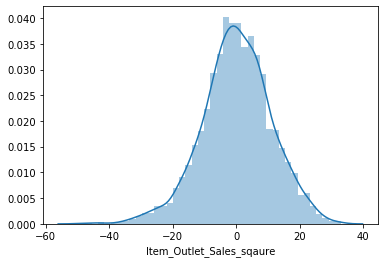

In [74]:
sns.distplot(y_valid-y_pred)

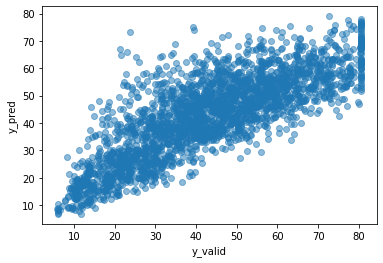

In [75]:
plt.scatter(y_valid, y_pred, alpha = 0.5)
plt.xlabel("y_valid")
plt.ylabel("y_pred")
plt.show()

In [76]:
print('MAE:', mean_absolute_error(y_valid, y_pred))
print('MSE:', mean_squared_error(y_valid, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_valid, y_pred)))
print('R2 score:', r2_score(y_valid, y_pred))

MAE: 8.541919477072984
MSE: 120.80579237353203
RMSE: 10.991168835639458
R2 score: 0.6413864181200356


In [77]:
#XGB regressor model
xgb_model=XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [78]:
xgb_pred=xgb_model.predict(X_valid)

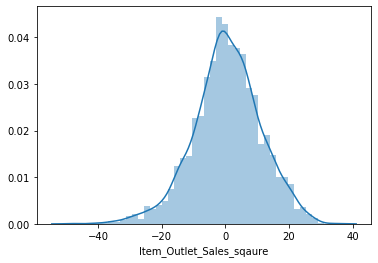

In [79]:
sns.distplot(y_valid-xgb_pred)

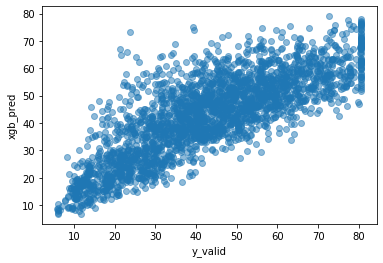

In [80]:
plt.scatter(y_valid, y_pred, alpha = 0.5)
plt.xlabel("y_valid")
plt.ylabel("xgb_pred")
plt.show()

In [81]:
print('MAE:', mean_absolute_error(y_valid, xgb_pred))
print('MSE:', mean_squared_error(y_valid, xgb_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_valid, xgb_pred)))
print('R2 score:', r2_score(y_valid, xgb_pred))

MAE: 8.252941996237327
MSE: 113.55292832786904
RMSE: 10.656121636311639
R2 score: 0.6629166403320748


The performance of xgb regressor seems to be better than the random forest regressor. 
So we can try hyper-parameter tuning on xgb model.
To tune the hyper-parameters RandomizedSearchCV and then GridSearchCV need to be used.

In [82]:
# define models and parameters
model = XGBRegressor()

n_estimators     = [100, 500, 1000, 1500]
learning_rate    = [0.03, 0.05, 0.07]
min_child_weight = [1,2,3]
max_depth        = [5,6,7]


# define grid search
grid = dict(n_estimators     = n_estimators, 
            learning_rate    = learning_rate,
            min_child_weight = min_child_weight,
            max_depth        = max_depth)

grid_search_xgb = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, 
                           scoring='r2',error_score=0,verbose=False,cv=5)

grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=0,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_cons...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
  

In [83]:
print(grid_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [84]:
grid_xgb_pred = grid_search_xgb.predict(X_valid)

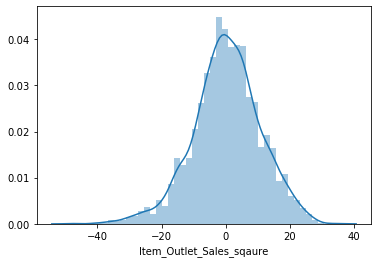

In [85]:
sns.distplot(y_valid-grid_xgb_pred)

In [86]:
print('MAE:', mean_absolute_error(y_valid, grid_xgb_pred))
print('MSE:', mean_squared_error(y_valid, grid_xgb_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_valid, grid_xgb_pred)))
print('R2 score:', r2_score(y_valid, grid_xgb_pred))

MAE: 8.18980551194063
MSE: 111.92325978387484
RMSE: 10.579378988573707
R2 score: 0.6677543328164868


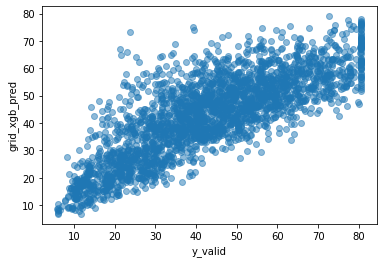

In [87]:
plt.scatter(y_valid, y_pred, alpha = 0.5)
plt.xlabel("y_valid")
plt.ylabel("grid_xgb_pred")
plt.show()

## Save the model

In [88]:
import pickle
# open a file, where you ant to store the data
file = open('bigmart_xgb.pkl', 'wb')

# dump information to that file
pickle.dump(grid_search_xgb, file)

In [89]:
model = open('bigmart_xgb.pkl','rb')
xgb_regressor = pickle.load(model)

In [90]:
y_prediction = xgb_regressor.predict(X_valid)
r2_score(y_valid, y_prediction)

0.6677543328164868

In [94]:
X.columns

Index(['Item_Weight_exp', 'Item_Visibility_sqaure', 'Item_MRP_exp',
       'Outlet_Age_sqaure', 'reg', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen_Foods', 'Fruits_and_Vegetables', 'Hard_Drinks',
       'Health_and_Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack_Foods', 'Soft_Drinks', 'Starchy_Foods', 'SM1', 'SM2', 'SM3',
       'Medium', 'Small', 'Tier_2', 'Tier_3', 'OUT013', 'OUT017', 'OUT018',
       'OUT019', 'OUT027', 'OUT035', 'OUT045', 'OUT046', 'OUT049'],
      dtype='object')